In [ ]:
import numpy as np # linear algebra
import pandas as pd # df processing, CSV file I/O (e.g. pd.read_csv)

# Input df files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#Emotion Detection using fine-tuned BERT.

In [ ]:
!wget https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py

--2023-11-28 02:58:20--  https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13881 (14K) [text/plain]
Saving to: ‘helper_prabowo_ml.py’

helper_prabowo_ml.p 100%[===================>]  13.56K  --.-KB/s    in 0s      

2023-11-28 02:58:20 (123 MB/s) - ‘helper_prabowo_ml.py’ saved [13881/13881]



#Install Transformers

In [ ]:
!pip install transformers

In [ ]:
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Import Data

In [ ]:
train = pd.read_csv("train.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
val = pd.read_csv("val.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
test = pd.read_csv("test.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')

#Data

In [ ]:
df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()

,index,Input,Sentiment
0,8017,i am still feeling some low energy and effects...,sadness
1,14693,i started to feel butterflies in my stomach an...,love
2,12563,i dont even think i would be ready to be fuck ...,sadness
3,1946,i feel for the kids of troubled homes and i fe...,sadness
4,11555,i thought we had done wrong by calling it off ...,joy


In [ ]:
df.drop('index',axis=1,inplace=True)
df.shape

(2000, 2)

#Text Preprocessing


##NLP Preprocessing

In [ ]:
def preprocess_data(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=lower)
    return data

In [ ]:
preprocessed_df = preprocess_data(df,'Input')
preprocessed_df.head()

,Input,Sentiment
0,still feeling low energy effects stress,sadness
1,started feel butterflies stomach body starting...,love
2,dont even think would ready fuck buddys theres...,sadness
3,feel kids troubled homes feel ones could chang...,sadness
4,thought done wrong calling suddenly didnt feel...,joy


##Adding num_words

In [ ]:
preprocessed_df['num_words'] = preprocessed_df.Input.apply(len)
preprocessed_df.head()

,Input,Sentiment,num_words
0,still feeling low energy effects stress,sadness,39
1,started feel butterflies stomach body starting...,love,54
2,dont even think would ready fuck buddys theres...,sadness,89
3,feel kids troubled homes feel ones could chang...,sadness,54
4,thought done wrong calling suddenly didnt feel...,joy,63


##Encode label

In [ ]:
encoded_labels = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}
train_data, test_data = train_test_split(preprocessed_df,test_size=0.3,random_state=101,shuffle=True,stratify=preprocessed_df.Sentiment)

#Loading tokennizer class and Pretrained BERT Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

##Plot num_words in Data

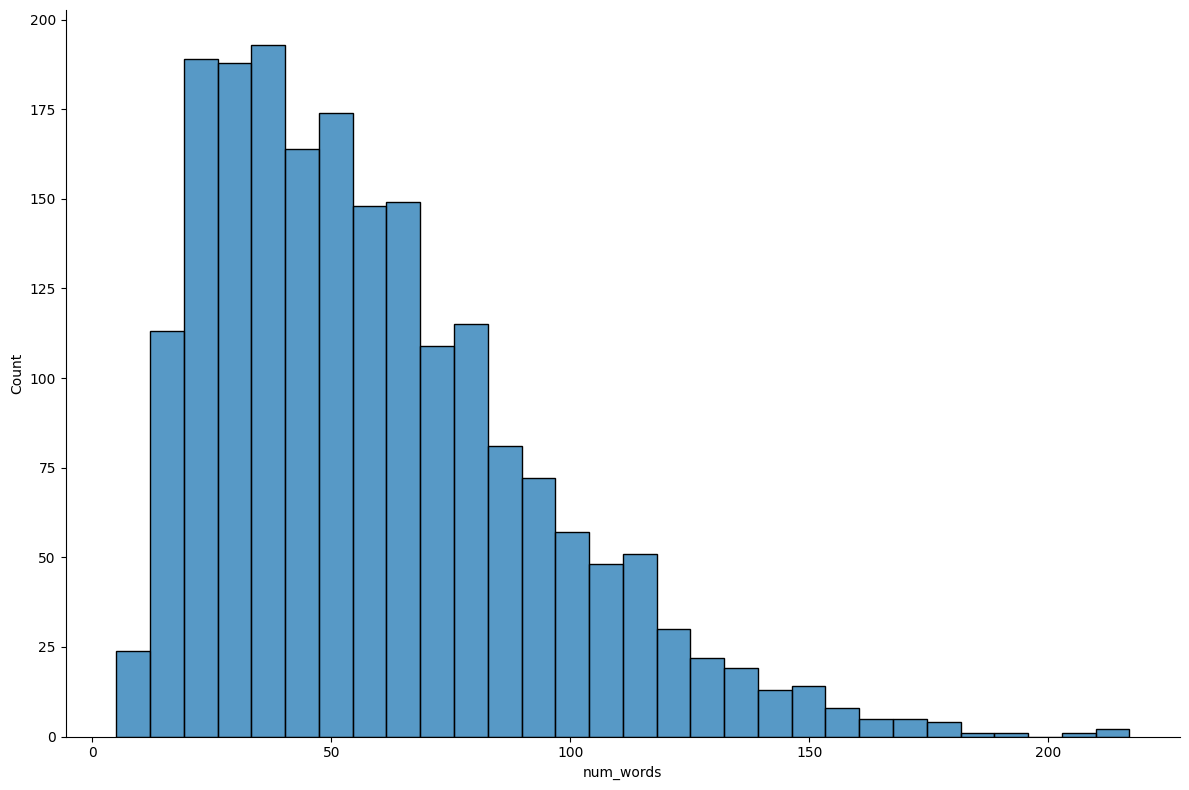

In [ ]:

sns.displot(preprocessed_df.num_words,height=8,aspect=1.5)

#Tokenizing
max_len = 39

In [ ]:
max_len = 39

#Tokenizer
X_train = tokenizer(text=train_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

X_test = tokenizer(text=test_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

#Model Architecture

In [ ]:
input_ids = Input(shape=(max_len,),name='input_ids',dtype=tf.int32)
attention_mask = Input(shape=(max_len,),name='attention_mask',dtype=tf.int32)

embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0: final hidden state, 1: pooling output
output = GlobalMaxPool1D()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=32,activation='relu')(output)
y = Dense(units=6,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=y)
model.layers[2].trainable = True

In [ ]:
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-5,epsilon=1e-8,decay=0.01,clipnorm=1.0),
              metrics=CategoricalAccuracy('balanced_accuracy'))

In [ ]:
train_data['Label'] = train_data.Sentiment.map(encoded_labels)
test_data['Label'] = test_data.Sentiment.map(encoded_labels)
train_data.head()

,Input,Sentiment,num_words,Label
637,everyone bit brief post ive got stinking cold ...,sadness,85,4
928,feel uptight day complete hes around feel righ...,fear,117,1
632,feel guilty feeling guilty health crisis damn ...,sadness,51,4
842,d write something interesting right unfortunat...,sadness,74,4
1472,feel frustrated te,anger,18,0


##Plot Model summary

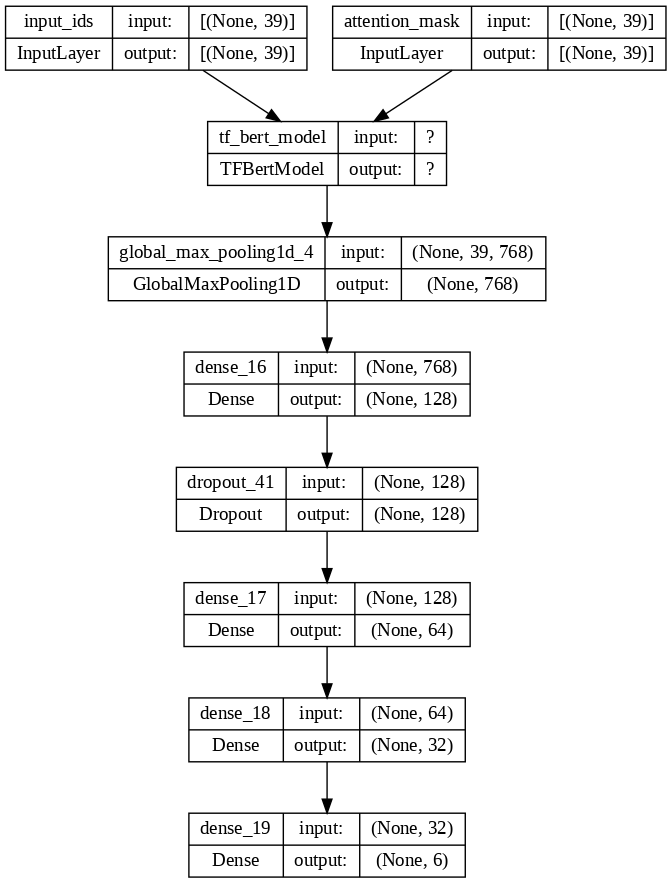

In [ ]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

##Model fit

In [ ]:
r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train_data.Label),
             epochs=10,
             batch_size=32,
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
             )

Epoch 1/10


44/44 [==============================] - 43s 411ms/step - loss: 0.5608 - balanced_accuracy: 0.8457 - val_loss: 0.4879 - val_balanced_accuracy: 0.8583
Epoch 2/10
44/44 [==============================] - 14s 326ms/step - loss: 0.2549 - balanced_accuracy: 0.9321 - val_loss: 0.4396 - val_balanced_accuracy: 0.8667
Epoch 3/10
44/44 [==============================] - 15s 331ms/step - loss: 0.1633 - balanced_accuracy: 0.9471 - val_loss: 0.4109 - val_balanced_accuracy: 0.8700
Epoch 4/10
44/44 [==============================] - 16s 357ms/step - loss: 0.0897 - balanced_accuracy: 0.9757 - val_loss: 0.4051 - val_balanced_accuracy: 0.8967
Epoch 5/10
44/44 [==============================] - 14s 329ms/step - loss: 0.0471 - balanced_accuracy: 0.9850 - val_loss: 0.4722 - val_balanced_accuracy: 0.8717
Epoch 6/10
44/44 [==============================] - 15s 339ms/step - loss: 0.0466 - balanced_accuracy: 0.9914 - val_loss: 0.4510 - val_balanced_accuracy: 0.8833
Epoch 7/10
44/44 [===========================

##Plot Model History

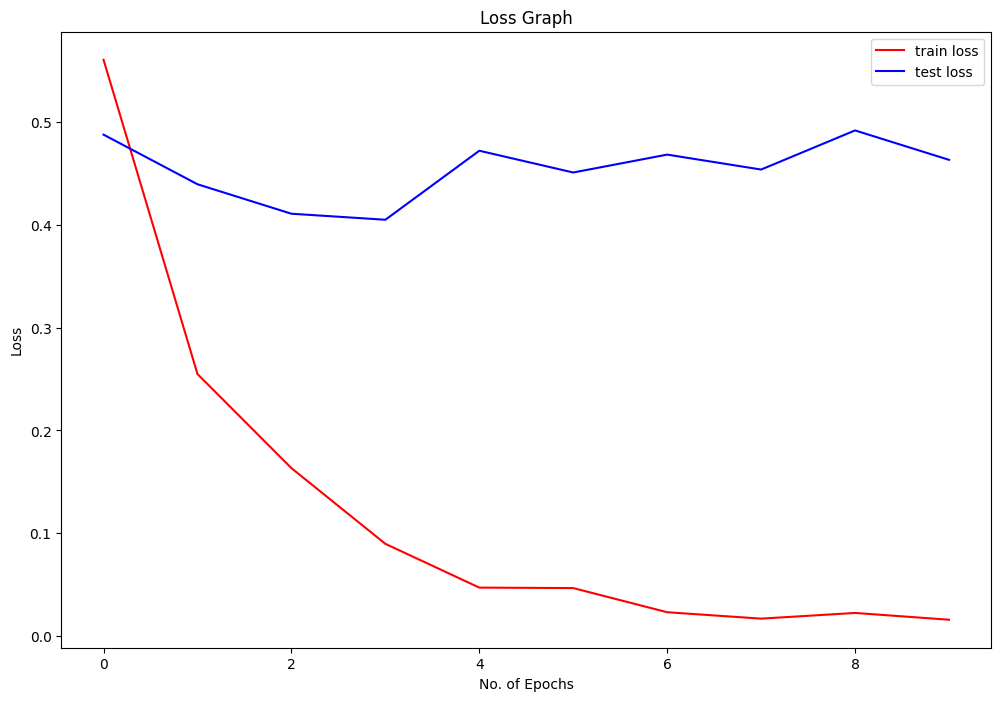

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

##Save Model

In [ ]:
model.save("emotion_detector.h5")

##Evaluate Model

In [ ]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
print("Test Categorical Cross-Entropy Loss:",loss)
print("Test Categorical Accuracy:",acc)

19/19 [==============================] - 2s 100ms/step - loss: 0.4634 - balanced_accuracy: 0.9017
Test Categorical Cross-Entropy Loss: 0.4633565843105316
Test Categorical Accuracy: 0.9016666412353516


##Predict and Classification Report

In [ ]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print(classification_report(test_data.Label,test_predictions))

19/19 [==============================] - 4s 90ms/step
              precision    recall  f1-score   support

           0       0.95      0.90      0.93        83
           1       0.79      0.85      0.82        73
           2       0.95      0.92      0.93       202
           3       0.82      0.88      0.85        48
           4       0.91      0.92      0.92       174
           5       0.77      0.85      0.81        20

    accuracy                           0.90       600
   macro avg       0.87      0.89      0.88       600
weighted avg       0.90      0.90      0.90       600

